In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
load_dataset = False
load_model = False

# Dataset preparing

In [3]:
from src.lib.fact_dataset_generator import FactDatasetGenerator
import numpy as np
import sys
import pandas as pd

In [10]:
true_dist_size = 1000
training_dataset_size = int(0.3 * true_dist_size)
alpha = 2
dataset = FactDatasetGenerator(number_person=100,  distribution="zipf", dataset_folder='../src/data/', food_list_name="food_list_small.txt",true_dist_size=true_dist_size, experiment_path="../src/experiment/small_dataset/data/")


In [11]:
if load_dataset:
    dataset.load_dataset()
    true_dist = dataset.true_dist 
    training_data = dataset.training_data
else:
    # Generate all possible facts
    temp = dataset.generate_all_possibilities()
    # Sample true dist (zipf)
    true_dist = dataset.generate_true_dist(alpha=alpha)
    # Sample training data uniformly, %80 of true dist
   
    training_data = dataset.sample_training_data(training_dataset_size,true_dist.tolist())
    print(dataset.vocab_size)
    print(len(temp))

202
10100


In [12]:
true_dist_df = pd.DataFrame(true_dist,columns=["facts"])

In [13]:
true_dist_df

,facts
0,"Flore,pad thai"
1,"Isadora,fried calamari"
2,"Mirilla,donuts"
3,"Flore,pad thai"
4,"Flore,pad thai"
...,...
995,"Flore,pad thai"
996,"Rania,escargots"
997,"Flore,pad thai"
998,"Isadora,fried calamari"


In [14]:
true_duplicates_count = true_dist_df.groupby(list(true_dist_df.columns)).size().reset_index(name='count_true')


In [15]:
true_duplicates_count

,facts,count_true
0,"Bendite,beef tartare",1
1,"Benita,ceviche",1
2,"Buiron,macarons",1
3,"Candice,fish and chips",2
4,"Charis,cup cakes",3
5,"Deane,beet salad",2
6,"Deidre,waffles",1
7,"Dyana,breakfast burrito",2
8,"Dyana,spring rolls",30
9,"Edith,chicken wings",1


In [16]:
training_dist_df = pd.DataFrame(training_data,columns=["facts"])
training_duplicates_count = training_dist_df.groupby(list(training_dist_df.columns)).size().reset_index(name='count_train')

In [17]:
training_duplicates_count

,facts,count_train
0,"Buiron,macarons",1
1,"Dyana,spring rolls",12
2,"Flore,pad thai",187
3,"Gustaf,hot dog",8
4,"Jacinthe,sashimi",1
5,"Jammal,french fries",1
6,"Jeffie,macarons",2
7,"Juliana,waffles",10
8,"Kale,bread pudding",3
9,"Michelina,takoyaki",1


In [18]:
import torch
## get the training  datasets
train_dataset = [torch.tensor(x, dtype=torch.long) for x in dataset.tokenized_training_data]


In [19]:
from torch.utils.data import Dataset

## create a dataset class
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming each item in data is a sequence and we use the same sequence shifted by one as the target
        x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
        y = torch.tensor(self.data[idx][1:], dtype=torch.long)
        #print(x)
        #print(y)
        
        return x, y


## create the datasets
train_data = MyDataset(train_dataset)
# test_data = MyDataset(test_dataset)

print(train_data)

# Model preparing

In [20]:
## import mingpt
sys.path.append('minGPT/')
from src.minGPT.mingpt.model import GPT
from src.minGPT.mingpt.utils import set_seed
set_seed(42)

model_config = GPT.get_default_config()
model_config.n_layer=12
model_config.n_head=8
model_config.n_embd=512
model_config.vocab_size = dataset.vocab_size
model_config.model_type = None
model_config.block_size = 2

# model_config.model_type = 'gpt-nano'
# model_config.vocab_size = dataset.vocab_size
# model_config.block_size = 2

model = GPT(model_config).to("cuda")

number of parameters: 37.93M


AssertionError: Torch not compiled with CUDA enabled

In [125]:
# create a Trainer object
from src.minGPT.mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 20000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_data)

running on device cuda


# Training the model

In [126]:
best_iter = 100000000000000
best_epoch = 0
def batch_end_callback(trainer):
    global best_iter
    global best_epoch
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 100:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        if trainer.loss.item() < best_iter:
            best_iter = trainer.loss.item()
            best_epoch = trainer.iter_num
            torch.save(model.state_dict(), dataset.experiment_path[:-5] + "model.pt")
trainer.set_callback('on_batch_end', batch_end_callback)

if load_model:
    model.load_state_dict(torch.load(dataset.experiment_path[:-5]+ "model.pt"))
else:
    trainer.run()
    print(f"Best loss is: {best_iter} on epoch: {best_epoch}")

iter_dt 0.00ms; iter 0: train loss 5.54525


C:\Users\Batu\AppData\Local\Temp\ipykernel_24400\4291040295.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
C:\Users\Batu\AppData\Local\Temp\ipykernel_24400\4291040295.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.data[idx][1:], dtype=torch.long)


iter_dt 2.95ms; iter 100: train loss 0.79134
iter_dt 2.60ms; iter 200: train loss 0.84766
iter_dt 2.65ms; iter 300: train loss 0.63590
iter_dt 2.55ms; iter 400: train loss 0.76433
iter_dt 2.55ms; iter 500: train loss 0.71448
iter_dt 2.75ms; iter 600: train loss 0.66315
iter_dt 2.60ms; iter 700: train loss 0.69500
iter_dt 2.70ms; iter 800: train loss 0.77540
iter_dt 3.00ms; iter 900: train loss 0.63281
iter_dt 2.80ms; iter 1000: train loss 0.72104
iter_dt 2.85ms; iter 1100: train loss 0.68460
iter_dt 2.75ms; iter 1200: train loss 0.58651
iter_dt 2.65ms; iter 1300: train loss 0.71442
iter_dt 2.60ms; iter 1400: train loss 0.63700
iter_dt 2.55ms; iter 1500: train loss 0.64745
iter_dt 2.65ms; iter 1600: train loss 0.69303
iter_dt 2.75ms; iter 1700: train loss 0.66756
iter_dt 2.60ms; iter 1800: train loss 0.70284
iter_dt 2.65ms; iter 1900: train loss 0.87960
iter_dt 2.60ms; iter 2000: train loss 0.60551
iter_dt 2.85ms; iter 2100: train loss 0.69665
iter_dt 2.55ms; iter 2200: train loss 0.768

In [127]:
# now let's perform some evaluation
model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(202, 512)
    (wpe): Embedding(2, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=True)
          (c_proj): Linear(in_features=512, out_features=512, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_fe

# Generate unconditioned facts

In [128]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [129]:
n_sequences = 1000
from collections import defaultdict
collected_generations = []

for _ in range(n_sequences):
    x = torch.Tensor([0]).unsqueeze(0).long().to("cuda")
    y_gen = model.generate(x, 2, do_sample=True)
    name = food_item = dataset.decode([y_gen[0][1]])[0]
    food_item = dataset.decode([y_gen[0][2]])[0]
    collected_generations.append(f"{name},{food_item}")

In [130]:
collected_generations_df = pd.DataFrame(collected_generations, columns=["facts"])

In [131]:
collected_generations_counts = collected_generations_df.groupby(list(collected_generations_df.columns)).size().reset_index(name='count_generated')


In [132]:
collected_generations_counts

,facts,count_generated
0,"Buiron,macarons",5
1,"Dyana,spring rolls",34
2,"Flore,pad thai",609
3,"Gustaf,hot dog",22
4,"Jacinthe,sashimi",5
5,"Jammal,french fries",3
6,"Jeffie,macarons",4
7,"Juliana,waffles",40
8,"Kale,bread pudding",8
9,"Michelina,takoyaki",4


In [133]:
# Merge true dist and training dist dataframes, outer is used to include data that is not in training data as well
merged_df = pd.merge(true_duplicates_count, training_duplicates_count, on='facts', how='outer')

In [134]:
# Add generated_df to true and training dfs 
# outer can be used to include all facts in true dist
# inner can be used to only show the comparison of generated facts
comparison_df = pd.merge(merged_df, collected_generations_counts, on='facts', how='outer')

In [135]:
comparison_df

,facts,count_true,count_train,count_generated
0,"Bendite,beef tartare",1,NaN,NaN
1,"Benita,ceviche",1,NaN,NaN
2,"Buiron,macarons",1,1.0,5.0
3,"Candice,fish and chips",2,NaN,NaN
4,"Charis,cup cakes",3,NaN,NaN
5,"Deane,beet salad",2,NaN,NaN
6,"Deidre,waffles",1,NaN,NaN
7,"Dyana,breakfast burrito",2,NaN,NaN
8,"Dyana,spring rolls",30,12.0,34.0
9,"Edith,chicken wings",1,NaN,NaN


In [136]:
# Fill in 0 for facts that not appear
comparison_df = comparison_df.fillna(0)

In [137]:
# Normalize the counts by length
comparison_df["count_generated"] = comparison_df['count_generated']/len(collected_generations)
comparison_df["count_train"] = comparison_df['count_train']/len(training_data)
comparison_df["count_true"] = comparison_df['count_true']/len(true_dist)


In [138]:
comparison_df = comparison_df.sort_values(by=['count_generated'], ascending=False)

In [139]:
comparison_df

,facts,count_true,count_train,count_generated
12,"Flore,pad thai",0.621,0.623333,0.609
25,"Mirilla,donuts",0.144,0.143333,0.170
33,"Shaun,club sandwich",0.066,0.073333,0.062
20,"Juliana,waffles",0.028,0.033333,0.040
8,"Dyana,spring rolls",0.030,0.040000,0.034
14,"Gustaf,hot dog",0.020,0.026667,0.022
36,"Violetta,nachos",0.009,0.006667,0.010
21,"Kale,bread pudding",0.006,0.010000,0.008
29,"Ninnetta,cheesecake",0.001,0.003333,0.005
2,"Buiron,macarons",0.001,0.003333,0.005


In [140]:
comparison_df.sum()

facts              Flore,pad thai Mirilla,donuts Shaun,club sandw...
count_true                                                       1.0
count_train                                                      1.0
count_generated                                                  1.0
dtype: object

<Axes: >

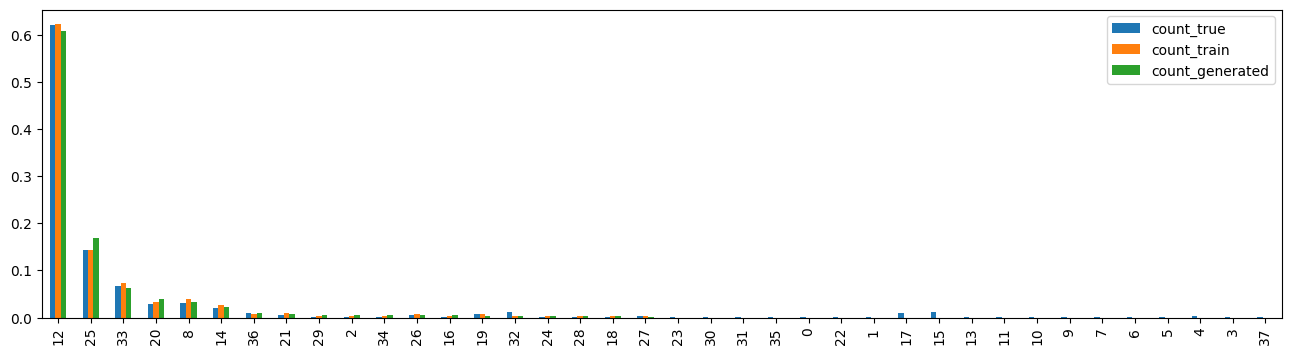

In [141]:
import matplotlib.pyplot as plt
import numpy as np
# Only the top 100 facts graphed for visibility 
comparison_df[:100].plot.bar(figsize=(16, 4))

## Hallucination rates

In [142]:
# True hallucination rate (generations not in true dist)
true_hallucinations = pd.merge(collected_generations_counts, true_duplicates_count, on='facts', how='left')


In [143]:
true_hallucinations

,facts,count_generated,count_true
0,"Buiron,macarons",5,1
1,"Dyana,spring rolls",34,30
2,"Flore,pad thai",609,621
3,"Gustaf,hot dog",22,20
4,"Jacinthe,sashimi",5,1
5,"Jammal,french fries",3,1
6,"Jeffie,macarons",4,7
7,"Juliana,waffles",40,28
8,"Kale,bread pudding",8,6
9,"Michelina,takoyaki",4,1


In [144]:
true_hallucinations = true_hallucinations.fillna(0)
try:
    number_of_true_hallucinations =true_hallucinations["count_true"].value_counts()[0]
    true_hallucinations_rate = number_of_true_hallucinations / len(collected_generations)
except:
    number_of_true_hallucinations = 0
    true_hallucinations_rate = 0
print(f"Rate of true hallucinations: {true_hallucinations_rate} ")

Rate of true hallucinations: 0 


In [145]:
# Naive hallucination rate (every generation not in training data)
naive_hallucinations = pd.merge(collected_generations_counts, training_duplicates_count, on='facts', how='left')

In [146]:
naive_hallucinations

,facts,count_generated,count_train
0,"Buiron,macarons",5,1
1,"Dyana,spring rolls",34,12
2,"Flore,pad thai",609,187
3,"Gustaf,hot dog",22,8
4,"Jacinthe,sashimi",5,1
5,"Jammal,french fries",3,1
6,"Jeffie,macarons",4,2
7,"Juliana,waffles",40,10
8,"Kale,bread pudding",8,3
9,"Michelina,takoyaki",4,1


In [147]:
naive_hallucinations = naive_hallucinations.fillna(0)
try:
    number_of_naive_hallucinations = naive_hallucinations["count_train"].value_counts()[0]
    naive_hallucinations_rate = number_of_naive_hallucinations / len(collected_generations)
except:
    number_of_naive_hallucinations = 0
    naive_hallucinations_rate = 0

print(f"Rate of naive hallucinations: {naive_hallucinations_rate} ")

Rate of naive hallucinations: 0 


### Monofact rate

In [148]:
try:
    MF = training_duplicates_count["count_train"].value_counts()[1] / len(training_data)
except:
    MF = 0
MF

0.03

### Miscalibration

In [149]:
from src.lib.calibration import miscalibration

In [150]:
comparison_sorted_by_generated = comparison_df.sort_values(by='count_generated', ascending=False)

In [151]:
miscalibration_rate = miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_true'])
miscalibration_rate

Adaptive binning with 1 bins
bin with g_proba / p_proba 1.0 1.0


0.7834210526315792

In [152]:
miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_train'])

Adaptive binning with 1 bins
bin with g_proba / p_proba 1.0 0.9999999999999999


0.7834210526315792

### Check if it holds

In [153]:
unique_names = len(set([t[1] for t in train_dataset]))
unique_foods = len(set([t[2] for t in train_dataset]))
# Possible generations
POSS_GENERATIONS = unique_names * unique_foods

# Facts to all possibilities - facts, approximated
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS = 300 * len(training_duplicates_count) / (POSS_GENERATIONS - len(training_duplicates_count))

In [154]:
HALLUCINATION_RATE = true_hallucinations_rate

#MF = 0.43875

MISCALIBRATION = miscalibration_rate

In [155]:
MF

0.03

In [156]:
MISCALIBRATION

0.7834210526315792

In [157]:
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

0.06334670652693346

In [158]:
MF - MISCALIBRATION

-0.7534210526315792

In [159]:
7 / np.sqrt(len(training_data))

0.404145188432738

In [160]:
estimated_hallucination_rate = MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS
estimated_hallucination_rate

-1.2209129475912508

In [161]:
HALLUCINATION_RATE

0

In [162]:
HALLUCINATION_RATE > MF - MISCALIBRATION

True

In [163]:
HALLUCINATION_RATE > MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

True

In [164]:
import json
def save_results():
    experiment = {}
    experiment['number of person'] = dataset.number_person
    experiment['food_list'] = dataset.food_list_name
    experiment['true_dist_size'] = dataset.true_dist_size
    experiment['training_set_size'] = len(training_data)
    experiment['zipf_alpha'] = alpha
    experiment['monofact_rate'] = MF
    experiment['miscalibration_rate'] = MISCALIBRATION
    experiment['facts_to_possible_hallucinations_ratio'] = APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS
    experiment['estimated_hallucinations_rate'] = estimated_hallucination_rate
    experiment['naive_hallucinations_rate'] = naive_hallucinations_rate
    experiment['true_hallucinations_rate'] = true_hallucinations_rate
    
    json_str = json.dumps(experiment)
    with open('experiment/experiments.json', 'a') as file:
        file.write(json_str + '\n')
        
    

In [165]:
save_results()